<a href="https://colab.research.google.com/github/tdegamboda/visual_semantic_reasoning/blob/master/Toy_Problem(Fashion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import sys
import time
import os
import math
import copy
import string
import re
from IPython.display import clear_output
import random
from random import choice

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from torch.autograd import Variable

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, GlobalMaxPool2D, Conv2D, MaxPooling2D, Flatten, GlobalMaxPool1D, Dense, Embedding, GRU, \
    Bidirectional, Concatenate, Lambda, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

We are going to import the genism model in order to implement the pretrained word2vec embeddings

In [ ]:
# https://stackoverflow.com/questions/55444572/how-does-i-unzip-pretrained-word2vec-in-google-colab
start_time = time.time()
!wget -P /tmp/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
elapsed_time = time.time() - start_time
print('Downloading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

--2020-09-25 10:09:32--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.77.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.77.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/tmp/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  85.0MB/s    in 20s     

2020-09-25 10:09:52 (79.8 MB/s) - ‘/tmp/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# Load Google's pre-trained Word2Vec model.
start_time = time.time()
word2Vec_filePath = '/tmp/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(word2Vec_filePath, binary=True)
!rm -f word2Vec_filePath
elapsed_time = time.time() - start_time
print('Loading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loading the pre-trained Word2Vec model took 88 seconds


In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
filepath_1 = "gdrive/My Drive/rfashionMNIST.npz"

data = np.load(filepath_1)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X, y_original), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
type(X)

numpy.ndarray

In [ ]:
#X = data['img']
y_positive = data['positive_labels']
y_test_labels = data['positive_labels_test']

In [ ]:
len(y_positive) == len(X), len(y_test) == len(x_test)

(True, True)

In [ ]:
int_to_label = {0 : "t-shirt", 1 : "trouser", 2 : "pullover", 3 : "dress", 4 : "coat", 5 : "sandal", 6 : "shirt", 7 : "sneaker", 8 : "bag", 9 : "boot"}

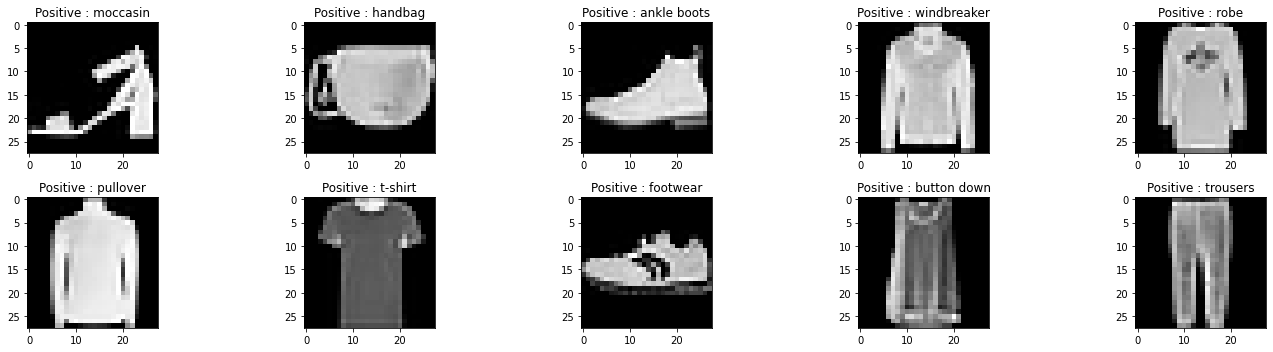

In [ ]:
fig2, ax2 = plt.subplots(2, 5, figsize = (20, 5))
list1 = []
count = 0
idx_list = list(range(len(y_original)))
np.random.shuffle(idx_list)
for i in idx_list:
    if y_original[i] not in list1:
        list1.append(y_original[i])

        ax = ax2[count // 5, count % 5]
        ax.imshow(X[i], cmap = 'gray')
        ax.set_title("Positive : " + y_positive[i])
        
        count += 1
plt.tight_layout()
plt.savefig('aug_fashionmnist.png', dpi = 1000)

plt.show()


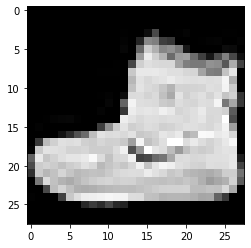

In [ ]:
plt.imshow(X[0], cmap = 'gray')
plt.savefig('fashionmnist_eg.png', dpi = 1000)

We will start be preprocessing the label descriptions. It is important that though we use label descriptions without punctuation, it is important that the tokenizer considers potential punctuation

In [ ]:
import string
import re

def remove_punctuation(strings):
    new_strings = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in strings if type(k) == str]
    lower_strings = [x.lower() for x in new_strings]
    alpha_strings = [x for x in lower_strings if all(word.isalpha() for word in x.split())]
    return alpha_strings

In [ ]:
y_positive_clean = remove_punctuation(y_positive.tolist())

In [ ]:
from collections import Counter

all_text = ' '.join(y_positive_clean)
words = all_text.split()

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [ ]:
vocab_to_int = {w:i for i,(w,c) in enumerate(sorted_words)}
int_to_vocab = {i:w for i,(w,c) in enumerate(sorted_words)}

vocab_size = len(vocab_to_int)

In order to handle unseen words we must include another token which handles these words

In [ ]:
vocab_to_int['UNK'] = vocab_size +1
int_to_vocab[vocab_size + 1] = 'UNK'

vocab_size  = len(vocab_to_int) + 1

In [ ]:
vocab_size

45

In [ ]:
# create array of train embeddings vectors to be fed into torch
emb_weights =  np.zeros((vocab_size, 300))

for key, val in int_to_vocab.items():
    if val in model.vocab:
        emb = model.get_vector(val)
        emb_weights[key] = emb

In [ ]:
#Delete the full Word2Vec model to free up disk space
del model

In [ ]:
def tokenizer(descriptions):
    sentence_tokens = []
    for sentence in descriptions:
        sent_tokens = []
        for word in sentence.split():
            sent_tokens.append(vocab_to_int.get(word, vocab_to_int["UNK"]))
        sentence_tokens.append(sent_tokens)
    return sentence_tokens

In [ ]:
positive_tokens = tokenizer(y_positive_clean)

In [ ]:
y_positive_clean[0].split()

['boots']

In [ ]:
positive_tokens[0]

[3]

In order to regulate the sentence length we will pad each description

In [ ]:
def padded_tokens(sentences, seq_len):
    #If sentence length is shorter than the seq_len we will pad the sentence with 0 and if the sentence is longer than the seq_len we will truncate the sentence
    padded_features = np.zeros((len(sentences), seq_len), dtype = int)
    for i, sentence in enumerate(sentences):
        if len(sentence) <= seq_len:
            padding = list(np.zeros(seq_len - len(sentence)))
            new = padding + sentence
        else:
            new = sentence[:seq_len]
        padded_features[i, :] = new
        
    return padded_features

In [ ]:
MAX_SEQ_LEN = 5

positive_tokens_pad = padded_tokens(positive_tokens, MAX_SEQ_LEN)

Now we will start to construct the model. This model's purpose is to map the image representation and the description semantic representation to the same vector space. We attempt to minimise the distance between the image and the positive label along with maximising the distance between the image and the negative label. To do this we will use triplet loss

In [ ]:
def triplet_loss(y_true, y_pred, alpha=0.7):
    """
    https://github.com/KinWaiCheuk/Triplet-net-keras/blob/master/Triplet%20NN%20Test%20on%20MNIST.ipynb
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    total_length = y_pred.shape.as_list()[-1]
    anchor = y_pred[:, 0:int(total_length * 1 / 3)]
    positive = y_pred[:, int(total_length * 1 / 3):int(total_length * 2 / 3)]
    negative = y_pred[:, int(total_length * 2 / 3):int(total_length * 3 / 3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor - positive), axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # compute loss
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)

    return loss


In [ ]:
import nltk
from itertools import chain
from nltk.corpus import wordnet

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def chunker(sequence, size, shuffle = False):
    seq = sequence.copy()
    if shuffle == True:
        random.shuffle(seq)
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]

In [ ]:
vec_dim = 50

class_labels = [["turtleneck", "top", "t-shirt", "tunic"],
                ["pants", "slacks", "trousers", "denims"],
                ["pullover", "jumper", "hoodie", "sweater"],
                ["dress", "gown", "frock", "robe"],
                ["coat", "jacket", "overcoat", "windbreaker"],
                ["slipper", "moccasin", "slip on", "sandal"],
                ["shirt", "button up", "button down", "polo"],
                ["sneaker", "running shoes", "footwear", "tennis shoes"],
                ["bag", "handbag", "purse", "backpack"],
                ["boots", "ankle boots", "galoshes", "snow shoes"]]

class_labels_flat = [x for class_ in class_labels for x in class_]


def gen(list_images, list_captions_positive, batch_size=16):
    indexes = list(range(len(list_images)))
    while True:
        batch_indexes = np.random.choice(indexes, batch_size, replace = False)

        candidate_images = [list_images[i].reshape(28, 28, 1) for i in batch_indexes]
        captions_p = [list_captions_positive[i] for i in batch_indexes]
        y_negative_ = []

        for i in batch_indexes:
            neg_label = np.random.choice([x for x in list(range(10)) if x != y_original[i]])
            y_negative_.append(class_labels[neg_label][np.random.randint(0,4)])

        y_negative_clean_ = remove_punctuation(y_negative_)
        neg_tokens = tokenizer(y_negative_clean_)
        captions_n = padded_tokens(neg_tokens, MAX_SEQ_LEN)

        X1 = np.array(candidate_images)
        X2 = np.array(captions_p)
        X3 = np.array(captions_n)

        yield [X1, X2, X3], np.zeros((batch_size, 3 * vec_dim))

In [ ]:
def gen_1(list_images, list_captions_positive, batch_size=16, shuffle_batches = True):
    indexes = list(range(len(list_images)))
    while True:

        batches = chunker(indexes, batch_size, shuffle = shuffle_batches)

        for batch_indexes in batches:

            candidate_images = [list_images[i].reshape(28, 28, 1) for i in batch_indexes]
            captions_p = [list_captions_positive[i] for i in batch_indexes]
            y_negative_ = [choice(class_labels_flat) for _ in batch_indexes]

            y_negative_clean_ = remove_punctuation(y_negative_)
            neg_tokens = tokenizer(y_negative_clean_)
            captions_n = padded_tokens(neg_tokens, MAX_SEQ_LEN)

            X1 = np.array(candidate_images)
            X2 = np.array(captions_p)
            X3 = np.array(captions_n)

            yield [X1, X2, X3], np.zeros((len(X1), 3 * vec_dim))

In [ ]:
next(gen_1(X, positive_tokens_pad))

([array([[[[  0],
           [  0],
           [  0],
           ...,
           [  0],
           [  0],
           [  0]],
  
          [[  0],
           [  0],
           [  0],
           ...,
           [  0],
           [  0],
           [  0]],
  
          [[  0],
           [  0],
           [  0],
           ...,
           [  0],
           [  0],
           [  0]],
  
          ...,
  
          [[  0],
           [  0],
           [  0],
           ...,
           [  0],
           [  0],
           [  0]],
  
          [[  0],
           [  0],
           [  0],
           ...,
           [  0],
           [  0],
           [  0]],
  
          [[  0],
           [  0],
           [  0],
           ...,
           [  0],
           [  0],
           [  0]]],
  
  
         [[[  0],
           [  0],
           [  0],
           ...,
           [  0],
           [  0],
           [  0]],
  
          [[  0],
           [  0],
           [  0],
           ...,
           [

In [ ]:
def model(vocab_size, lr=0.0001):
    input_1 = Input(shape=(28, 28, 1))
    input_2 = Input(shape=(None,))
    input_3 = Input(shape=(None,))

    conv_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1), name = "conv_1")

    pool_1 = MaxPooling2D((2, 2), name = "pool_1")

    dense_1 = Dense(vec_dim, activation = 'linear', name = "dense_image_1")

    x1 = conv_1(input_1)
    x1 = pool_1(x1)
    x1 = Flatten()(x1)
    x1 = dense_1(x1)

    embed = Embedding(vocab_size, 300, weights=[emb_weights],  name="word2vec_embed", trainable = False)

    gru = Bidirectional(GRU(256, return_sequences=True), name="gru_1")
    dense_2 = Dense(vec_dim, activation="linear", name="dense_text_1")

    x2 = embed(input_2)
    x2 = gru(x2)
    x2 = GlobalMaxPool1D()(x2)
    x2 = dense_2(x2)

    x3 = embed(input_3)
    x3 = gru(x3)
    x3 = GlobalMaxPool1D()(x3)
    x3 = dense_2(x3)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)
    x2 = _norm(x2)
    x3 = _norm(x3)

    x = Concatenate(axis=-1)([x1, x2, x3])

    model = Model([input_1, input_2, input_3], x)

    model.compile(loss=triplet_loss, optimizer=Adam(lr))

    model.summary()

    return model


In [ ]:
model = model(vocab_size = vocab_size, lr=0.00001)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 26, 26, 32)   320         input_1[0][0]                    
_______________________________________________________________________________________

In [ ]:
#Split the data into train and val
from sklearn.model_selection import train_test_split

idx_list = list(range(len(X)))
train_idx, val_idx = train_test_split(idx_list, test_size = 0.2, shuffle = True)

train_imgs, train_p_captions = X[train_idx], positive_tokens_pad[train_idx]
val_imgs, val_p_captions = X[val_idx], positive_tokens_pad[val_idx]

In [ ]:
file_path = "model_triplet.h5"
BATCH_SIZE = 32

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_ = ReduceLROnPlateau(monitor="val_loss", mode='min', patience=5, min_lr=1e-7)

model.fit(gen_1(train_imgs, train_p_captions, batch_size=BATCH_SIZE),
                    use_multiprocessing=True,
                    validation_data=gen_1(val_imgs, val_p_captions, batch_size=BATCH_SIZE), epochs=100,
                    verbose=1, workers=-1, steps_per_epoch=np.ceil(len(train_imgs) / BATCH_SIZE), validation_steps= np.ceil(len(val_imgs) / BATCH_SIZE), callbacks=[es, checkpoint, reduce_])
model.save_weights(file_path)

Epoch 1/100
1497/1500 [============================>.] - ETA: 0s - loss: 0.2399
Epoch 00001: val_loss improved from inf to 0.16071, saving model to model_triplet.h5
1500/1500 [==============================] - 17s 12ms/step - loss: 0.2398 - val_loss: 0.1607
Epoch 2/100
1500/1500 [==============================] - ETA: 0s - loss: 0.1420
Epoch 00002: val_loss improved from 0.16071 to 0.14052, saving model to model_triplet.h5
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1420 - val_loss: 0.1405
Epoch 3/100
1500/1500 [==============================] - ETA: 0s - loss: 0.1326
Epoch 00003: val_loss improved from 0.14052 to 0.12349, saving model to model_triplet.h5
1500/1500 [==============================] - 17s 11ms/step - loss: 0.1326 - val_loss: 0.1235
Epoch 4/100
1498/1500 [============================>.] - ETA: 0s - loss: 0.1255
Epoch 00004: val_loss improved from 0.12349 to 0.12019, saving model to model_triplet.h5
1500/1500 [==============================] - 17s 

Now we will use our test images in order to create an image query model. First we establish seperate models to encode the images and text. 

In [ ]:
def image_model(lr=0.0001):

    input_1 = Input(shape=(28,28,1))

    conv_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1), name = "conv_1")

    pool_1 = MaxPooling2D((2, 2), name = "pool_1")

    dense_1 = Dense(vec_dim, activation = 'linear', name = "dense_image_1")

    x1 = conv_1(input_1)
    x1 = pool_1(x1)
    x1 = Flatten()(x1)
    x1 = dense_1(x1)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)

    model = Model([input_1], x1)

    model.compile(loss="mae", optimizer=Adam(lr))

    model.summary()

    return model


def text_model(vocab_size, lr=0.0001):
    input_2 = Input(shape=(None,))

    embed = Embedding(vocab_size, 300, weights=[emb_weights],  name="word2vec_embed", trainable = False)
    gru = Bidirectional(GRU(256, return_sequences=True), name="gru_1")
    dense_2 = Dense(vec_dim, activation="linear", name="dense_text_1")

    x2 = embed(input_2)
    x2 = gru(x2)
    x2 = GlobalMaxPool1D()(x2)
    x2 = dense_2(x2)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x2 = _norm(x2)

    model = Model([input_2], x2)

    model.compile(loss="mae", optimizer=Adam(lr))

    model.summary()

    return model

In [ ]:
t_model = text_model(vocab_size = vocab_size)
i_model = image_model()

t_model.load_weights(file_path, by_name=True)
i_model.load_weights(file_path, by_name=True)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
word2vec_embed (Embedding)   (None, None, 300)         13500     
_________________________________________________________________
gru_1 (Bidirectional)        (None, None, 512)         857088    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_text_1 (Dense)         (None, 50)                25650     
_________________________________________________________________
lambda_7 (Lambda)            (None, 50)                0         
Total params: 896,238
Trainable params: 882,738
Non-trainable params: 13,500
__________________________________________

In [ ]:
test_imgs = x_test

First we will encode the images

In [ ]:
def chunker(seq, size):
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]

In [ ]:
from tqdm import tqdm


target_image_encoding = []

for img in tqdm(chunker(test_imgs, 128), total=len(test_imgs)//128):
    image_vecs = np.asarray([img[i].reshape(28, 28, 1) for i in range(len(img))])
    e = i_model.predict(image_vecs)
    target_image_encoding += e.tolist()

79it [00:02, 33.96it/s]


Now we will consider a series of potential query texts in order to extract the most relevant images

In [ ]:
query_text = ["shirt", "boots", "car", "sweater"]

cleaned_text = remove_punctuation(query_text)
query_tokens = tokenizer(cleaned_text)
pad_query_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

target_text_encoding = t_model.predict(np.asarray(pad_query_tokens), verbose = 2)

1/1 - 0s


In [ ]:
np.shape(target_text_encoding)

(4, 50)

In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_jobs=-1, n_neighbors=9)
nn.fit(target_image_encoding)

preds = nn.kneighbors(target_text_encoding, return_distance=False)

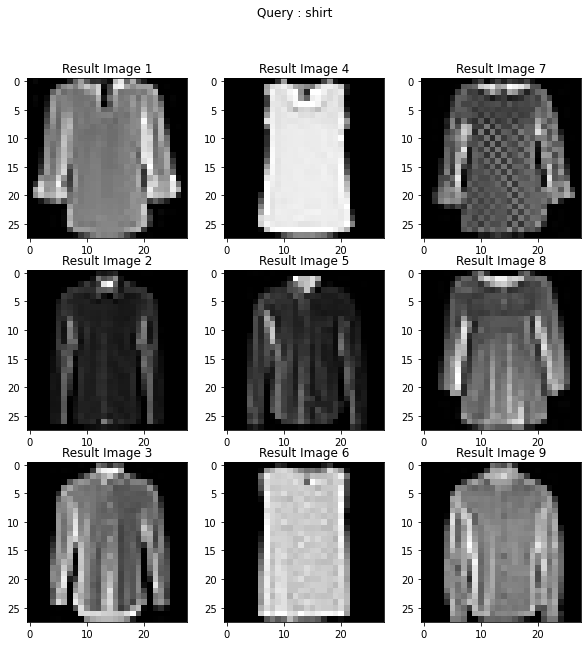

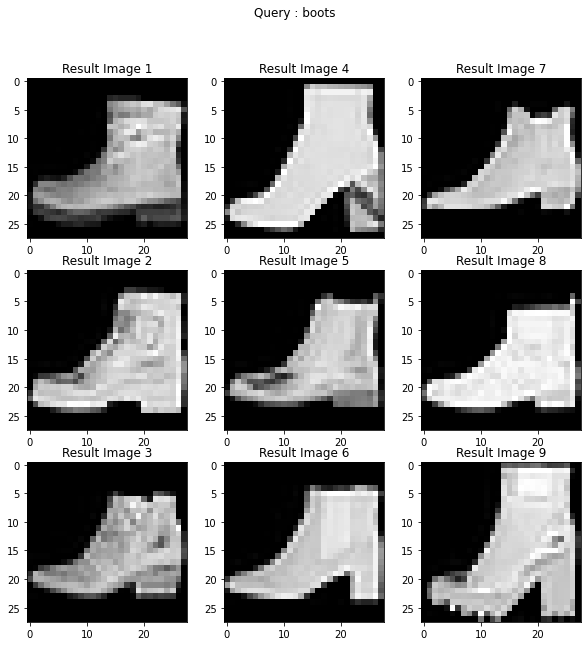

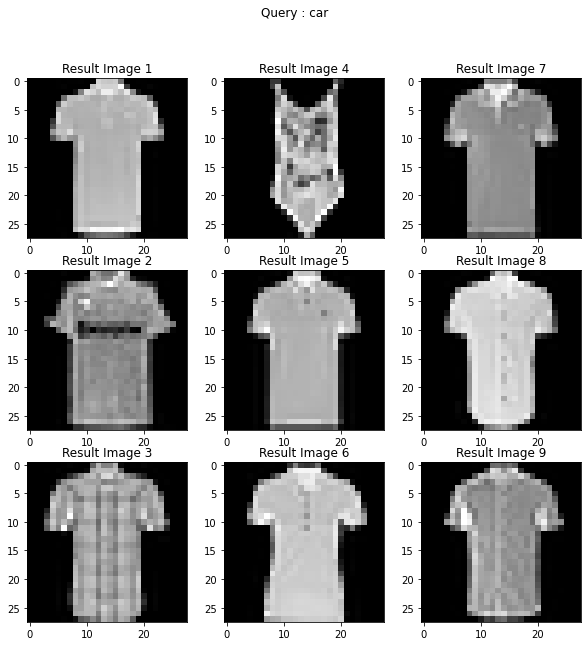

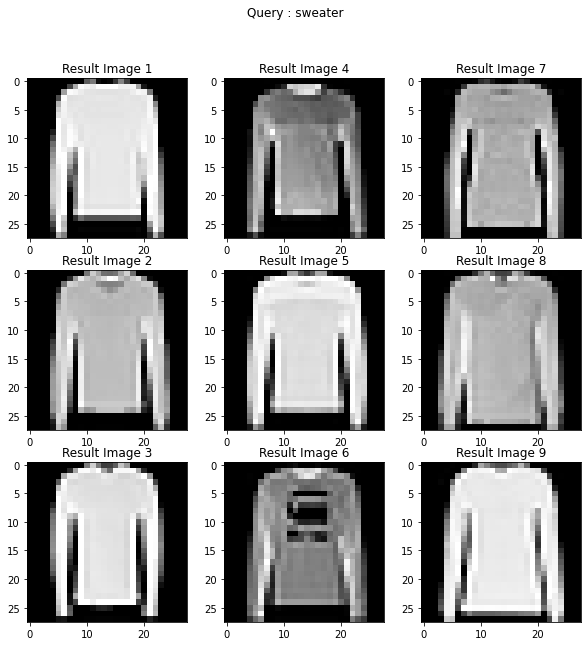

In [ ]:
most_similar_images = []
query_image = []


for i in range(len(preds)):
    pred_imgs = test_imgs[preds[i].tolist()]
    most_similar_images.append(pred_imgs)

for q, all_images in zip(query_text, most_similar_images):
    fig, axes = plt.subplots(3, 3, figsize = (10, 10))

    for idx, img_path in enumerate(all_images):
        i = idx % 3  # Get subplot row
        j = idx // 3  # Get subplot column
        axes[i, j].imshow(img_path, cmap = 'gray')
        axes[i, j].set_title('Result Image %s'%(idx+1))


    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    fig.suptitle('Query : %s'%q)

# Evaluation

In [ ]:
type(y_test_labels)

numpy.ndarray

In [ ]:
test_text = ['top',
 'trousers',
 'jumper',
 'robe',
 'jacket',
 'moccasin',
 'button down',
 'tennis shoes',
 'bag',
 'snow shoes']

test_text = y_test_labels.tolist()

cleaned_text = remove_punctuation(test_text)
query_tokens = tokenizer(cleaned_text)
pad_query_tokens = padded_tokens(query_tokens, MAX_SEQ_LEN)

target_text_encoding = t_model.predict(np.asarray(pad_query_tokens), verbose = 2)

313/313 - 1s


In [ ]:
nn = NearestNeighbors(n_jobs=-1, n_neighbors=len(test_text))
nn.fit(target_text_encoding)

dists, preds = nn.kneighbors(target_image_encoding, return_distance=True)

all_label_distances = np.zeros_like(dists)

for i, (dist, pred) in enumerate(zip(dists, preds)):
    label_distances = [x for y, x in sorted(zip(pred, dist))]
    all_label_distances[i] = label_distances

In [ ]:
pos_neg_class_distances = []
class_bin_labels = []
for class_id in range(10):
    bin_labels = [1 if x == class_id else 0 for x in y_test]
    pos_dist = [all_label_distances[i, class_id] for i, x in enumerate(bin_labels) if x == 1]
    neg_dist = [all_label_distances[i, class_id] for i, x in enumerate(bin_labels) if x == 0]

    pos_neg_class_distances.append((pos_dist, neg_dist))
    class_bin_labels.append(bin_labels)

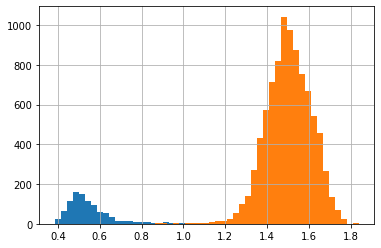

In [ ]:
pos_, neg_ = pos_neg_class_distances[1]

pd.Series(pos_).hist(bins = 40)

pd.Series(neg_).hist(bins = 40)

plt.savefig('distance_distributions.png', dpi = 1000)

plt.show()



In [ ]:
def pred_mapping(distances, threshold):
    binary_preds = []
    for dist in distances:
        if dist <= threshold:
            binary_preds.append(1)
        else:
            binary_preds.append(0)
    return binary_preds

In [ ]:
pos_neg_class_distances[0][0]

[0.5290951287070232,
 0.6260692147728867,
 0.7079845878752286,
 0.7337146564885154,
 0.5928699778834148,
 0.6684672351265321,
 0.49164590718123924,
 0.7823974569206887,
 0.5469092737875945,
 0.8123675463009186,
 0.5657827481805981,
 0.5207005281009821,
 0.7614217168159759,
 0.6656738515630576,
 0.6201328132228997,
 0.8277039276884081,
 0.6140019199500457,
 0.8455155419051837,
 0.6419844602287769,
 0.5326694661404121,
 0.699729463880863,
 0.6168225476300627,
 0.5209585087218453,
 0.6525231756511702,
 0.6517746122709687,
 0.5181545896247465,
 0.6518954048504144,
 0.5424740578666952,
 0.5821969601516028,
 0.547499253657508,
 0.715413629149829,
 0.7102006676512098,
 0.6058775168952862,
 0.521085709223588,
 1.2839988095612982,
 0.7298352509985346,
 0.8378518065453668,
 0.9120412636430637,
 0.597965999050043,
 0.5159595320470421,
 0.7409804842837786,
 0.6050675901135277,
 0.5887864753553043,
 0.5378612956374085,
 0.7537328299230001,
 0.5828691534544915,
 0.7858897987271077,
 1.30893208334839

In [ ]:
from sklearn.metrics import accuracy_score

thresholds = [[1.0, 1.1, 1.2], [1.0, 1.1, 1.2], [0.9, 1.0, 1.1, 1.2], [1.1, 1.2, 1.3], [1.0, 1.1, 1.2], [1.0, 1.1, 1.2], [1.1, 1.2, 1.3], [1.0, 1.1, 1.2], [1.1, 1.2, 1.3], [1.0, 1.1, 1.2]]
best_thresholds = []
best_accs = []

for i, threshold in enumerate(thresholds):
    pos_dists, neg_dists = pos_neg_class_distances[i]
    best_acc = 0
    best_threshold = 0
    best_pos_acc = 0
    for x in threshold:
        bin_pos = pred_mapping(pos_dists, x)
        bin_neg = pred_mapping(neg_dists, x)

        pos_acc = accuracy_score(bin_pos, [1]*len(bin_pos))
        neg_acc = accuracy_score(bin_neg, [0]*len(bin_neg))

        mean_acc = np.mean([pos_acc, neg_acc])

        if mean_acc > best_acc:
            best_acc = mean_acc
            best_threshold = x
            best_pos_acc = pos_acc
            
    best_thresholds.append(best_threshold)
    best_accs.append(best_pos_acc)

In [ ]:
mean_class = np.mean(best_accs)

In [ ]:
mean_class

0.9603999999999999

In [ ]:
a = []

b = ([1, 2, 3], [4, 5, 6])

In [ ]:
a.append(b)

In [ ]:
a

[([1, 2, 3], [4, 5, 6])]

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
a = np.array([[0, 1, 2], [3, 4, 5]])
a.flatten()

array([0, 1, 2, 3, 4, 5])

In [ ]:
test_flat = [x.flatten() / 255.0 for x in test_imgs]

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=70)
tsne_results = tsne.fit_transform(target_image_encoding)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 8.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.201565
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.550461
[t-SNE] KL divergence after 1000 iterations: 1.376520


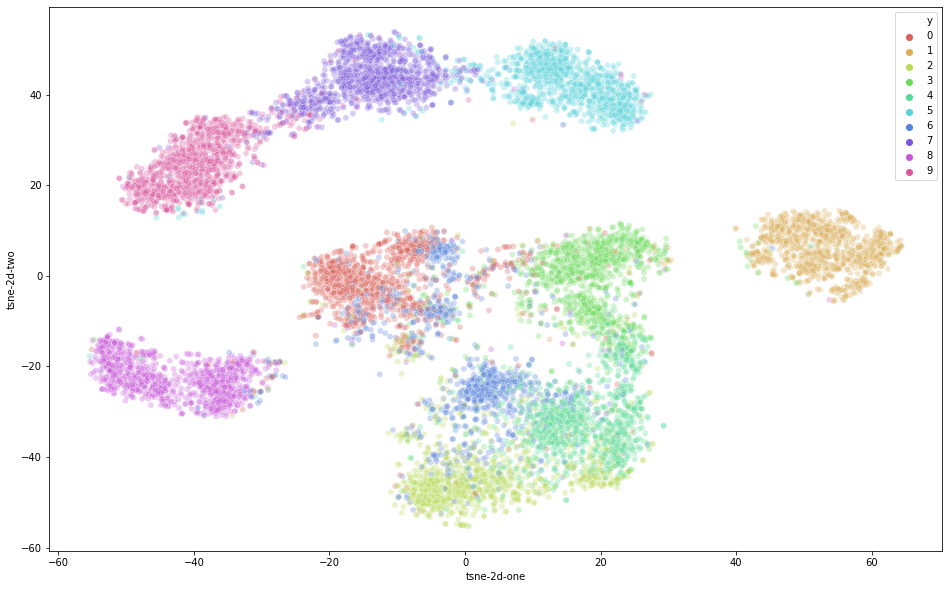

In [ ]:
df_subset = pd.DataFrame()

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = y_test
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

plt.savefig('t_sne_plot_after.png', dpi = 700)